<a href="https://colab.research.google.com/github/Aymanjeb/VitAI/blob/main/Data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import numpy as np
from imblearn.over_sampling import SMOTE #over sampling library

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report,f1_score,confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score


We load data that was previously saved in data pre-processing and modeling file. Categorical features are already encoded we only need to scale numerical features

In [ ]:
with open('data/features_encoded.pkl', 'rb') as f:
    data_encoded = pickle.load(f)
with open('data/target.pkl', 'rb') as f:
    target = pickle.load(f)

In [ ]:
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(data_encoded, target)
columns = smote.get_feature_names_out(data_encoded.columns)
print("Number of patients with heart attack risk :", np.sum(y_bal==1))
print("Number of patients without heart attack risk:", np.sum(y_bal==0))

Number of patients with heart attack risk : 5624
Number of patients without heart attack risk: 5624


We can see that we have the same number of samples in each class

In [ ]:
numerical_columns = ['Exercise Hours Per Week',
 'Stress Level',
 'Sedentary Hours Per Day',
 'BMI',
 'Triglycerides',
 'Physical Activity Days Per Week',
 'Sleep Hours Per Day']

num_pipeline = Pipeline([
    ("scaler",StandardScaler())
])
preprocess_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, numerical_columns)
    ]
    , remainder="passthrough")

We can use train_test_split to split our data

In [ ]:
train_data, test_data, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
X_train = preprocess_pipeline.fit_transform(
    train_data)
X_test = preprocess_pipeline.transform(test_data)


We reduce the dimentionality of our data

In [ ]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
print("Number of components after appying PCA is : ", pca.n_components_)
X_test_pca = pca.transform(X_test)


Number of components after appying PCA is :  38


We reuse the same function defined in the other file

In [ ]:
lregression = LogisticRegression(class_weight='balanced',random_state=42)
rfclassifier = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=6)
xgbclassifier = XGBClassifier(random_state=42)
svc = SVC(random_state=42,kernel="sigmoid", class_weight='balanced')
mlpclassifier = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='lbfgs',random_state=42, max_iter=2000, learning_rate="invscaling")
models = [lregression, rfclassifier, xgbclassifier, svc, mlpclassifier]
names = ["LogisticRegression", "RandomForestClassifier", "XGBClassifier", "SVC", "MLPClassifier"]


def statistics_models(X_train,X_test, y_train, y_test, show=False):
    conf_matrices = []
    classifiers = []
    f1_scores, Accuracies = {}, {}
    for classifier, name in zip(models, names):
        scores = cross_val_score(classifier, X_train, y_train, cv=10)
        classifier.fit(X_train, y_train)
        y_train_pred = classifier.predict(X_train)
        y_pred = classifier.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        conf_matrices.append(cm)
        classifiers.append(name)
        f1_scores[name] = [f1_score(y_train_pred, y_train),f1_score(y_test, y_pred)]
        Accuracies[name] = [scores.mean(), accuracy_score(y_test,y_pred)]
        if show:
            print(f"Score of {name} : ", scores.mean())
            print(f"F1 score of {name} on test data : ", f1_scores[name][1])
            print(f"Summary of {name} on test data : \n", classification_report(y_test, y_pred))

    return conf_matrices, classifiers, f1_scores, Accuracies


In [ ]:
conf_matrices, classifiers, f1_scores, Accuracies = statistics_models(X_train_pca,X_test_pca, y_train, y_test)

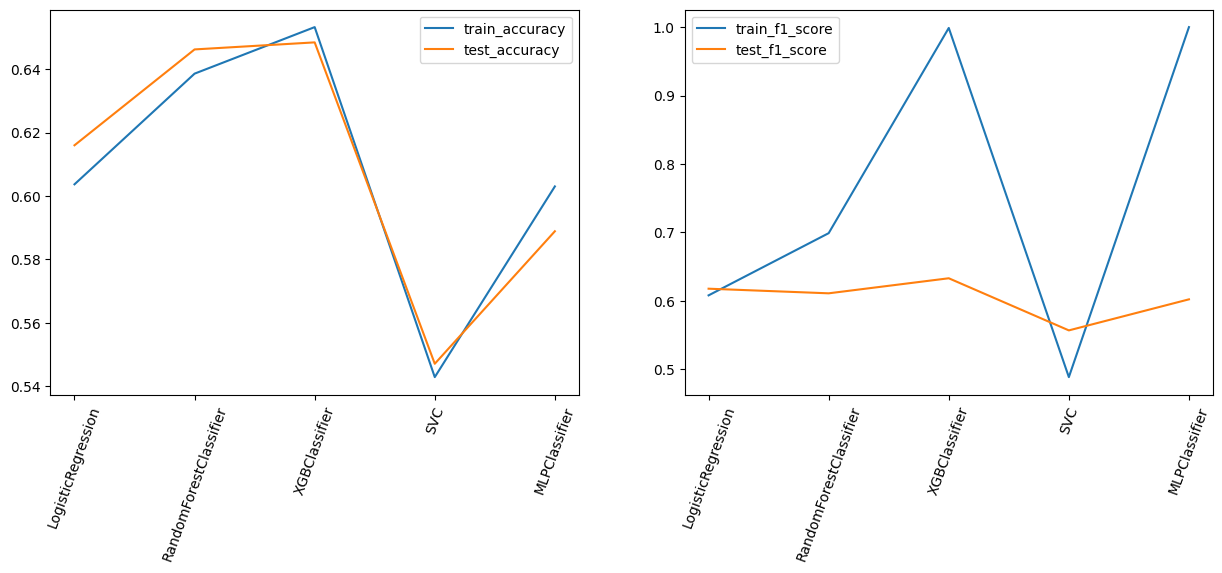

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(Accuracies.keys(), [Accuracy[0] for Accuracy in Accuracies.values()], label = "train_accuracy")
axs[0].plot(Accuracies.keys(), [Accuracy[1] for Accuracy in Accuracies.values()], label = "test_accuracy")
axs[0].legend()
axs[0].tick_params(axis='x', labelrotation=70)

axs[1].plot(f1_scores.keys(), [f1[0] for f1 in f1_scores.values()], label = "train_f1_score")
axs[1].plot(f1_scores.keys(), [f1[1] for f1 in f1_scores.values()], label = "test_f1_score")
axs[1].legend()
axs[1].tick_params(axis='x', labelrotation=70)

plt.show()

We clearly see that accuracy and f1-score values increased. But we shouldn't forget that the test data here was also over sampled. Let's try to work on a separate test set (without over sampling) and see if we'll get the same results.

Number of patients with heart attack risk : 4499
Number of patients without heart attack risk: 4499
Number of components after applying PCA is :  38


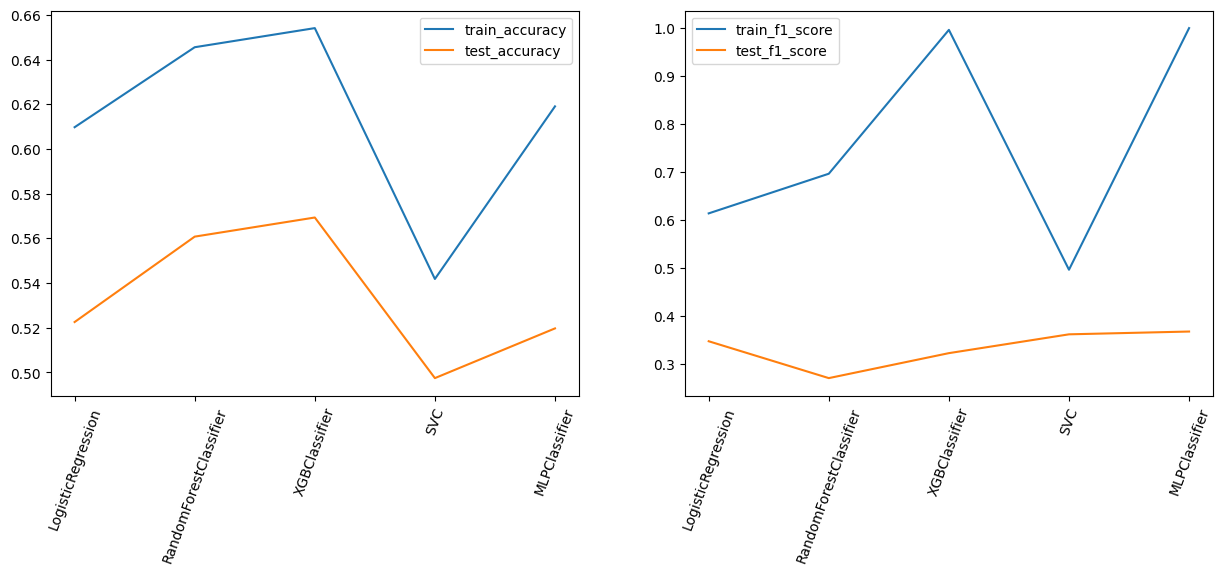

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(data_encoded, target):
    train_data, test_data = data_encoded.iloc[train_index], data_encoded.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(train_data, y_train)
columns = smote.get_feature_names_out(train_data.columns)
print("Number of patients with heart attack risk :", np.sum(y_train_bal==1))
print("Number of patients without heart attack risk:", np.sum(y_train_bal==0))

X_train = preprocess_pipeline.fit_transform(
    X_train_bal)
X_test = preprocess_pipeline.transform(test_data)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
print("Number of components after applying PCA is : ", pca.n_components_)
X_test_pca = pca.transform(X_test)

conf_matrices_2, classifiers_2, f1_scores_2, Accuracies_2 = statistics_models(X_train_pca,X_test_pca, y_train_bal, y_test)

############
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(Accuracies_2.keys(), [Accuracy[0] for Accuracy in Accuracies_2.values()], label = "train_accuracy")
axs[0].plot(Accuracies_2.keys(), [Accuracy[1] for Accuracy in Accuracies_2.values()], label = "test_accuracy")
axs[0].legend()
axs[0].tick_params(axis='x', labelrotation=70)

axs[1].plot(f1_scores_2.keys(), [f1[0] for f1 in f1_scores_2.values()], label = "train_f1_score")
axs[1].plot(f1_scores_2.keys(), [f1[1] for f1 in f1_scores_2.values()], label = "test_f1_score")
axs[1].legend()
axs[1].tick_params(axis='x', labelrotation=70)

plt.show()


It seems that over sampling didn't help our model to gain more knowledge about our data. F1-score values are even worse than before.